<a href="https://colab.research.google.com/github/RWLab/crypto-pod/blob/main/research/trend-momentum-spot-analysis/update_2023/8%20-%20Ranking%20cross%20sectional%20factors.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Ranking Cross-Sectional Features

Previously we used a simple `row_number` function to rank cross-sectional features having sorted by feature value. This led to certain situations where different coins had the same feature value, but were arbitrarily ranked.

In this notebook we correct that by using a ranking function that ensures that coins with the same feature value receive the same rank (and therefore the same weight).

We find that this impacts the cross-sectional days since high feature (it was the main feature impacted by the arbitrary ranking scheme). It now looks a bit worse, which suggests that we got a bit lucky with our arbitrary ranking scheme for this factor.


## Load libraries and authenticate

In [1]:
# snippet: rw load rwRtools v0.8
source("https://raw.githubusercontent.com/RWLab/rwRtools/master/examples/colab/load_libraries.R")
# debug_msg <- load_libraries(load_rsims = TRUE, extra_libraries = c('lubridate', "tibbletime","roll","RcppRoll","Hmisc","Rcpp", "patchwork"), extra_dependencies = c('RcppParallel',"Formula", "gridExtra", "htmlTable", "checkmate", "htmlwidgets", "viridis"))
debug_msg <- load_libraries(load_rsims = TRUE, extra_libraries = c('lubridate', "tibbletime","roll","RcppRoll","Rcpp", "patchwork"), extra_dependencies = c('RcppParallel'))

# cat(debug_msg)

# Set chart options
options(repr.plot.width = 14, repr.plot.height=7)
theme_set(theme_bw())
theme_update(text = element_text(size = 20))

Using 2  CPUs for package installation

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

Installing packages into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)



── R CMD build ─────────────────────────────────────────────────────────────────
* checking for file ‘/tmp/RtmpuhbYMV/remotes29e6e433d94/RWLab-rwRtools-d04d163/DESCRIPTION’ ... OK
* preparing ‘rwRtools’:
* checking DESCRIPTION meta-information ... OK
* checking for LF line-endings in source and make files and shell scripts
* checking for empty or unneeded directories
Omitted ‘LazyData’ from DESCRIPTION
* building ‘rwRtools_0.1.63.tar.gz’

── R CMD build ─────────────────────────────────────────────────────────────────
* checking for file ‘/tmp/RtmpuhbYMV/remotes29e3fbc9f05/Robot-Wealth-rsims-2589683/DESCRIPTION’ ... OK
* preparing ‘rsims’:
* checking DESCRIPTION meta-information ... OK
* cleaning src
* checking for LF line-endings in source and make files and shell scripts
* checking for empty or unneeded directories
* building ‘rsims_1.1.0.4.tar.gz’



In [2]:
# snippet: rw data auth v.0.1
rwlab_data_auth()

Authorization successful!

## Load Coincodex daily data

In [3]:
# snippet: rw crypto load coincodex data v0.1
market_cap <- rwRtools::crypto_get_coincodex() %>%
  select(Ticker, Date, MarketCapUSD)

head(market_cap)

ℹ Downloading coincodex_marketcap.feather

✔ Saved coincodex_marketcap.feather to coincodex/coincodex_marketcap.feather  (…





File successfully transferred


Ticker,Date,MarketCapUSD
<chr>,<date>,<dbl>
TGC,2017-01-01,1.461090e+04
ATOM,2017-01-02,9.059482e+04
BTC,2017-01-02,1.634320e+10
DASH,2017-01-02,8.113380e+07
DCR,2017-01-02,1.638005e+06
DGB,2017-01-02,2.012658e+06


## Load Binance spot data

In [4]:
prices <- rwRtools::crypto_get_binance_spot_1h()
head(prices)

ℹ Downloading binance_spot_1h.feather

✔ Saved binance_spot_1h.feather to binance/binance_spot_1h.feather  ( 804.5 Mb )





File successfully transferred


Ticker,Datetime,Open,High,Low,Close,Volume,Quote asset volume,Number of trades,Taker buy base asset volume,Taker buy quote asset volume
<chr>,<dttm>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<int>,<dbl>,<dbl>
BTCUSDT,2017-08-17 04:00:00,4261.48,4313.62,4261.32,4308.83,47.181009,202366.14,171,35.160503,150952.48
ETHUSDT,2017-08-17 04:00:00,301.13,302.57,298.00,301.61,125.668770,37684.80,129,80.563770,24193.44
BTCUSDT,2017-08-17 05:00:00,4308.83,4328.69,4291.37,4315.32,23.234916,100304.82,102,21.448071,92608.28
ETHUSDT,2017-08-17 05:00:00,301.61,303.28,300.00,303.10,377.672460,114043.28,202,328.104280,99079.80
BTCUSDT,2017-08-17 06:00:00,4330.29,4345.45,4309.37,4324.35,7.229691,31282.31,36,4.802861,20795.32
ETHUSDT,2017-08-17 06:00:00,302.40,304.44,301.90,302.68,303.866720,92034.44,182,259.286680,78525.95


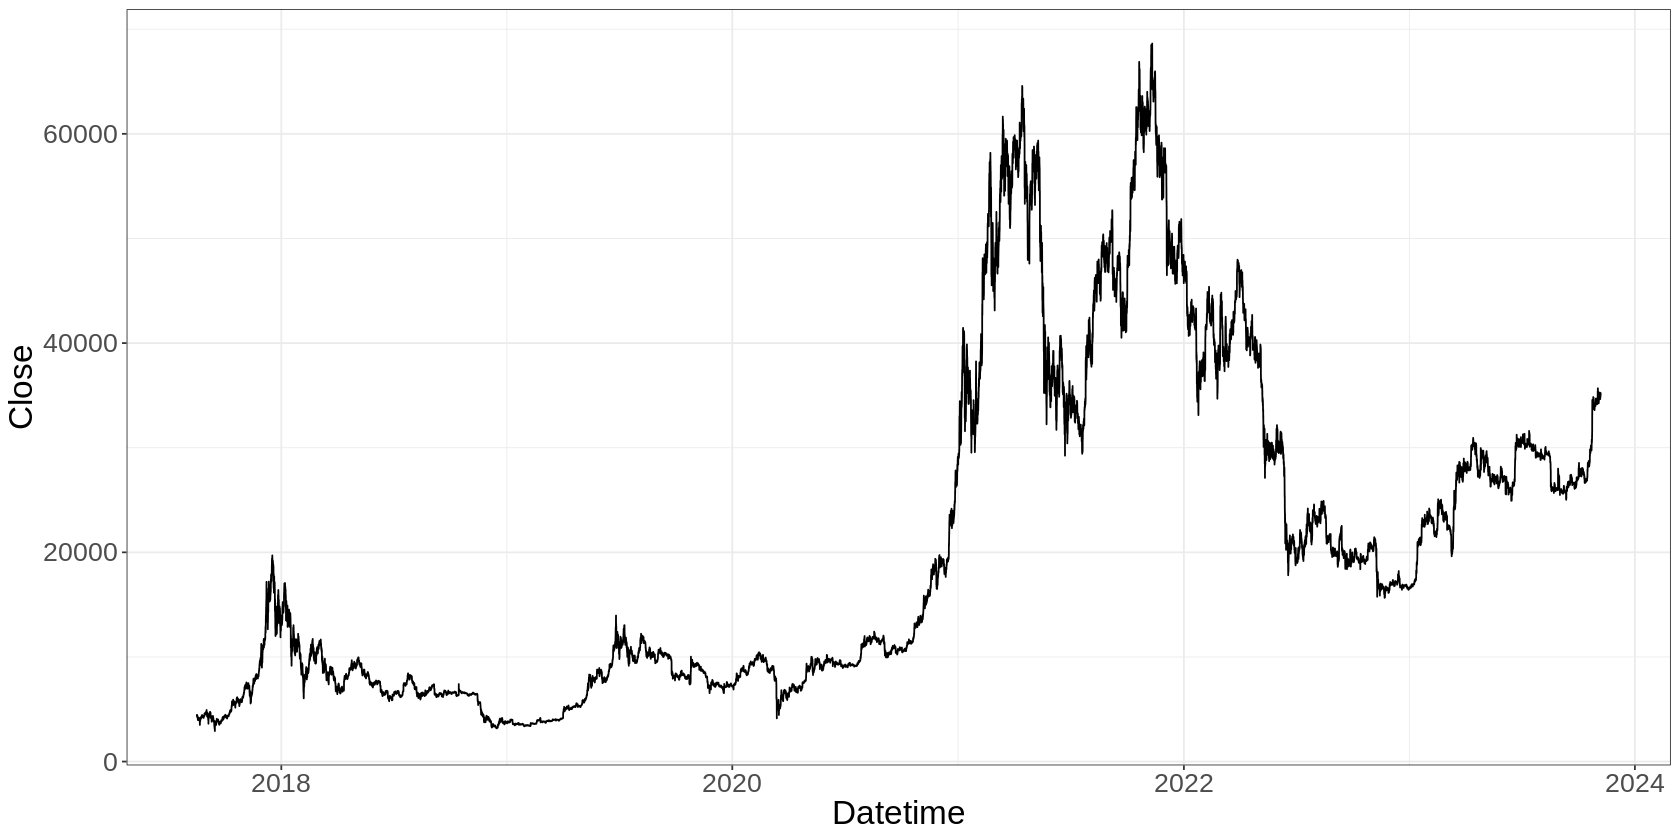

In [58]:
prices %>% filter(Ticker == "BTCUSDT") %>% ggplot(aes(x = Datetime, y = Close)) + geom_line()

## Create research universe

In [78]:
#' prices: Binance hourly OHLCV spot data
create_binance_daily_snapshots <- function(prices, snapshot_hour=12) {
  prices %>%
    # retain only the data we need and ditch USDT part of Ticker
    select(Ticker, Datetime, Close) %>%
    mutate(Ticker = str_replace(Ticker, "USDT$", "")) %>%
   # take a daily snapshot at a particular time
    mutate(
      Hour = hour(Datetime),
      Date = as_date(Datetime)
    ) %>%
    filter(Hour == snapshot_hour) %>%
    select(Date, Ticker, Close)
}

#' market_cap: market cap data from coincodex
create_binance_universe <- function(prices, market_cap, n=10, min_constituents=10, stables, to_remove) {
  # Remove stablecoins and others
  prices <- prices %>%
    filter(!Ticker %in% c(stables, to_remove))

   # remove from market_cap data anything that wasn't trading on Binance or is a stable/duplicate
  binance_tickers <- pull(prices, Ticker)
  market_cap <- market_cap %>%
    filter(!Ticker %in% c(stables, to_remove)) %>%
    filter(Ticker %in% binance_tickers)

  # Get first date where we have min_constituents
  start_date <- prices %>%
    group_by(Date) %>%
    summarise(count = n()) %>%
    filter(count >= min_constituents) %>%
    summarise(mindate = min(Date)) %>%
    pull(mindate)

  start_date <- start_date + 1

  # Flag universe consitutents
  # For a given ticker/date observation, set is_index to TRUE if:
  #    - the asset was in the top 10 coins by market cap the day before
  #    - the date is on or after the date when we have min_consituents assets in our dataset
  binance_universe <- prices %>%
    # this will remove any tickers that were removed from the prices data
    left_join(market_cap, by = c("Ticker", "Date")) %>%
    # where remaining tickers are missing market cap data, fill forward
    group_by(Ticker) %>%
    arrange(Date) %>%
    fill(MarketCapUSD, .direction = "down") %>%
    na.omit() %>%
    # but we need to create a new universe based on the remaining binance tickers (not all coincodex tickers were trading on binance)
    group_by(Date) %>%
    mutate(cap_rank = row_number(desc(MarketCapUSD))) %>%
    arrange(Date) %>%
    group_by(Ticker) %>%
    mutate(is_index = lag(cap_rank) <= n & Date >= start_date) %>%
    na.omit() %>%
    ungroup()
}

# create daily snapshots
daily_prices <- prices %>%
  create_binance_daily_snapshots(snapshot_hour = 0)

# list of stablecoins from defi llama
url <- "https://stablecoins.llama.fi/stablecoins?includePrices=true"
response <- httr::GET(url)

stables <- response %>%
  content(as = "text", encoding = "UTF-8") %>%
  jsonlite::fromJSON(flatten = TRUE) %>%
  pluck("peggedAssets") %>%
  pull(symbol)

# duplicates and others to remove
to_remove <- c('BTCD', 'HBTC', 'IBBTC', 'RBTC', 'SBTC3', 'WNXM', 'WBTC', 'BNBBULL', 'BNBBEAR', 'EOSBULL', 'EOSBEAR', 'ETHBULL', 'ETHBEAR', 'XRPBULL', 'XRPBEAR')

# create universe
universe <- create_binance_universe(daily_prices, market_cap, n=10, min_constituents=10, stables=stables, to_remove=to_remove)

head(universe)

Date,Ticker,Close,MarketCapUSD,cap_rank,is_index
<date>,<chr>,<dbl>,<dbl>,<int>,<lgl>
2017-08-18,BTC,4286.53,70206129858,1,FALSE
2017-08-18,ETH,301.19,28406320026,2,FALSE
2017-08-19,BTC,4163.49,67500579074,1,FALSE
2017-08-19,ETH,295.44,27839631816,2,FALSE
2017-08-20,BTC,4086.09,68107644316,1,FALSE
2017-08-20,ETH,287.00,27787997159,2,FALSE


# Utility Code

In [6]:
library(Rcpp)
cppFunction(
  code = 'NumericVector ema(NumericVector vec, int window) {
    double smoothing_factor = 2.0;
    double alpha = smoothing_factor/(window + 1);
    double beta = 1.0 - alpha;

    NumericVector ema = {vec[0]};
    if (vec.size() > 0 ) {
      for (int i = 1; i != vec.size(); ++i) { // Start iterating from  + 1 because I need the last value
          ema.push_back((vec[i] * alpha) + (ema[i-1] * beta));

        }
      return ema;
    }
}'
)

# Cross-Sectional Factors

In [80]:
rolling_days_since_high_30 <- purrr::possibly(
  tibbletime::rollify(
    function(x) {
      idx_of_high <- which.max(x)
      days_since_high <- length(x) - idx_of_high
      days_since_high
    },
    window = 30, na_value = NA),
  otherwise = NA
)

mom_factor_wide <- universe %>%
  group_by(Ticker) %>%
  arrange(Date) %>%
  # Close momo factor
  mutate(
    x_mom_15 = log(Close / lag(Close, n = 15)),
    x_mom_20 = log(Close / lag(Close, n = 20)),
    x_mom_25 = log(Close / lag(Close, n = 25)),
  ) %>%
  # Close to SMA factor
  mutate(
    x_psma_20 = Close / roll_meanr(Close, 20) - 1,
    x_psma_25 = Close / roll_meanr(Close, 25) - 1,
    x_psma_30 = Close / roll_meanr(Close, 30) - 1,
  ) %>%
  # SMA ratio factor
  mutate(
    x_smaf_3_20 = roll_meanr(Close, 3) / roll_meanr(Close, 20) - 1,
    x_smaf_3_25 = roll_meanr(Close, 3) / roll_meanr(Close, 25) - 1,
    x_smaf_5_30 = roll_meanr(Close, 5) / roll_meanr(Close, 30) - 1.
  ) %>%
  # Range over recent history
  mutate(
    x_rrp_10 = (Close - roll_meanr(Close, n = 10)) / roll_sdr(Close, n = 10),
    x_rrp_15 = (Close - roll_meanr(Close, n = 15)) / roll_sdr(Close, n = 15),
    x_rrp_25 = (Close - roll_meanr(Close, n = 25)) / roll_sdr(Close, n = 25)
  ) %>%
  # Range
  mutate(
    x_range_10 = (Close - roll_minr(Close, n = 10)) / (roll_maxr(Close, n = 10) - roll_minr(Close, n = 10)),
    x_range_15 = (Close - roll_minr(Close, n = 15)) / (roll_maxr(Close, n = 15) - roll_minr(Close, n = 15)),
    x_range_25 = (Close - roll_minr(Close, n = 25)) / (roll_maxr(Close, n = 25) - roll_minr(Close, n = 25))
  ) %>%
  # Days since last high factor
  mutate(
    x_dsh_30 = -rolling_days_since_high_30(Close)
  ) %>%
  # Calculate returns
  mutate(
    fwd_return_1 = lead(Close,1) / Close - 1,
    fwd_return_2 = lead(Close,2) / lead(Close, 1) - 1,
    fwd_return_3 = lead(Close,3) / lead(Close, 2) - 1,
    fwd_log_return_1 = log(lead(Close) / Close),
    fwd_log_return_2 = log(lead(Close,2) / lead(Close, 1)),
    fwd_log_return_3 = log(lead(Close,3) / lead(Close, 2))
  ) %>%
  na.omit() %>%
  ungroup()

In [129]:
mom_ranks <- mom_factor_wide %>%
  pivot_longer(starts_with('x_'), names_to = 'feature', values_to = 'value') %>%
  filter(is_index) %>%
  group_by(Date, feature) %>%
  mutate(
    # rank = row_number(value),  # previous approach
    rank = min_rank(value),
    weight = rank - mean(rank),
    # scaled_weight = weight/sum(abs(weight)),
    scaled_weight = case_when(
      sum(abs(weight)) == 0 ~ 0,  # happens when all the weights are zero, f.i. when the x_dsh factors are all past their lookback period and all get the same rank
      TRUE ~ weight/sum(abs(weight))
    ),
    weighted_fwd_return_1 = fwd_return_1 * scaled_weight,
    weighted_fwd_return_2 = fwd_return_2 * scaled_weight,
    weighted_fwd_return_3 = fwd_return_3 * scaled_weight
  )

In [130]:
# data where all the coins get the same feature value
# mom_ranks %>% filter(feature == "x_dsh_30") %>% filter(Date >= "2018-07-07") %>% head(10)

In [131]:
mom_factor <- mom_ranks %>%
  group_by(Date, feature) %>%
  summarise(
    log_factor_return_1 = log(sum(weighted_fwd_return_1) + 1),
    log_factor_return_2 = log(sum(weighted_fwd_return_2) + 1),
    log_factor_return_3 = log(sum(weighted_fwd_return_3) + 1)
  ) %>%
  group_by(feature) %>%
  arrange(Date) %>%
  # Cumulative Returns
  mutate(
    gap_0 = cumsum(log_factor_return_1),
    gap_1 = cumsum(log_factor_return_2),
    gap_2 = cumsum(log_factor_return_3)
  ) %>%
  # Rolling returns
  mutate(
    rolling_gap_0 = roll_meanr(log_factor_return_1, 90) * 365,
    rolling_gap_1 = roll_meanr(log_factor_return_2, 90) * 365,
    rolling_gap_2 = roll_meanr(log_factor_return_3, 90) * 365
  )

`summarise()` has grouped output by 'Date'. You can override using the
`.groups` argument.


## Cumulative Long/Short Factor Returns

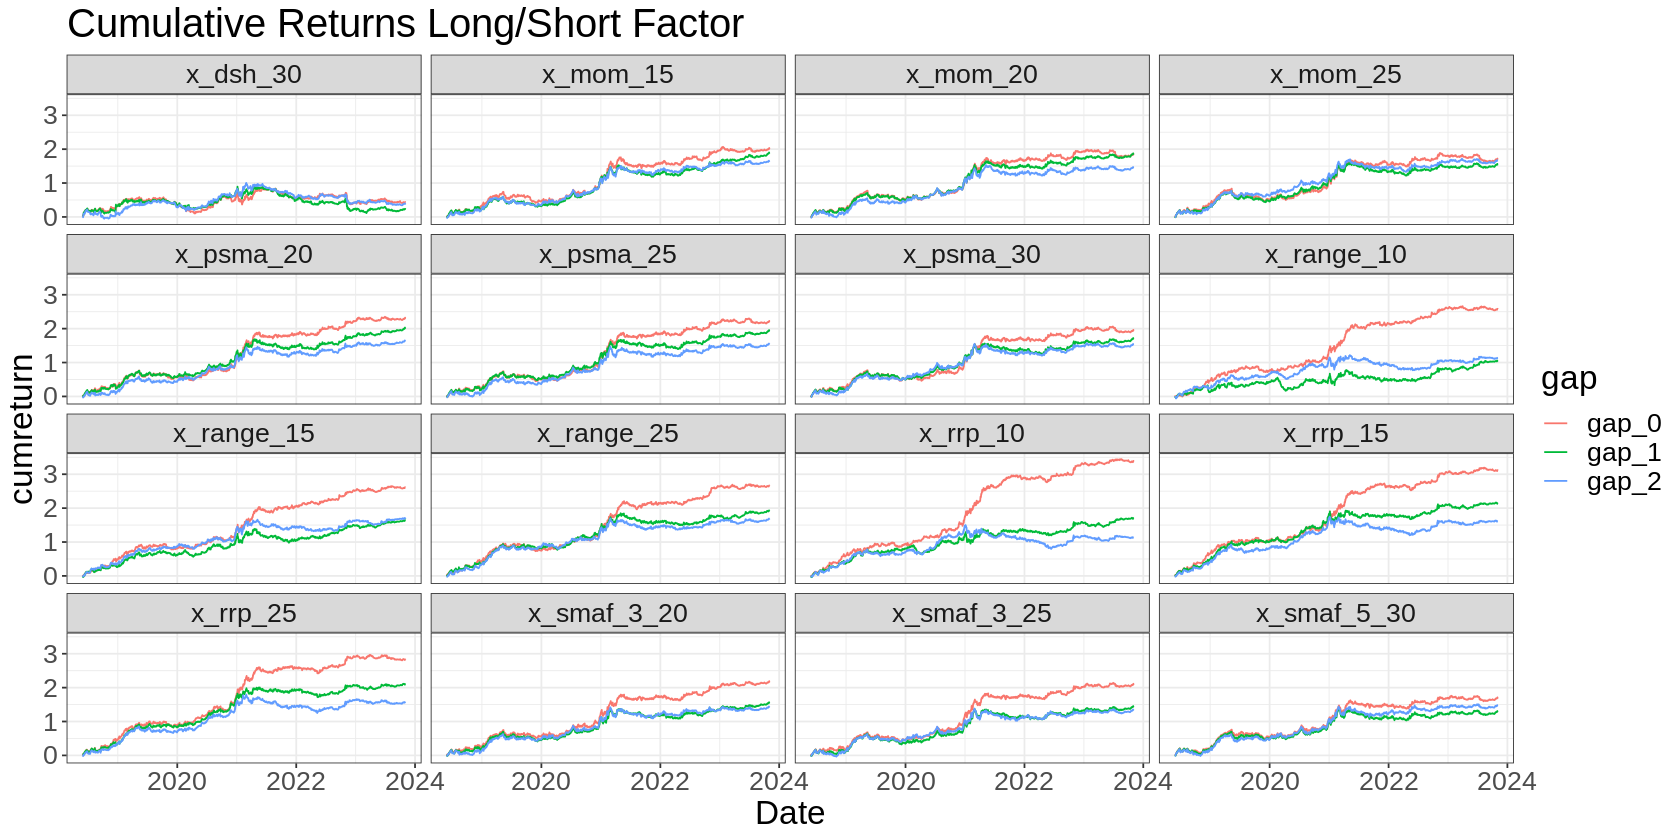

In [132]:
# Cumulative Returns Plot
mom_factor %>%
  pivot_longer(starts_with('gap_'), names_to = 'gap', values_to = 'cumreturn') %>%
  ggplot(aes(x=Date, y=cumreturn, color = gap)) +
  geom_line() +
  facet_wrap(~feature) +
  ggtitle('Cumulative Returns Long/Short Factor')

## Rolling Long/Short Factor Returns

Warning message:
“Removed 267 rows containing missing values (`geom_line()`).”


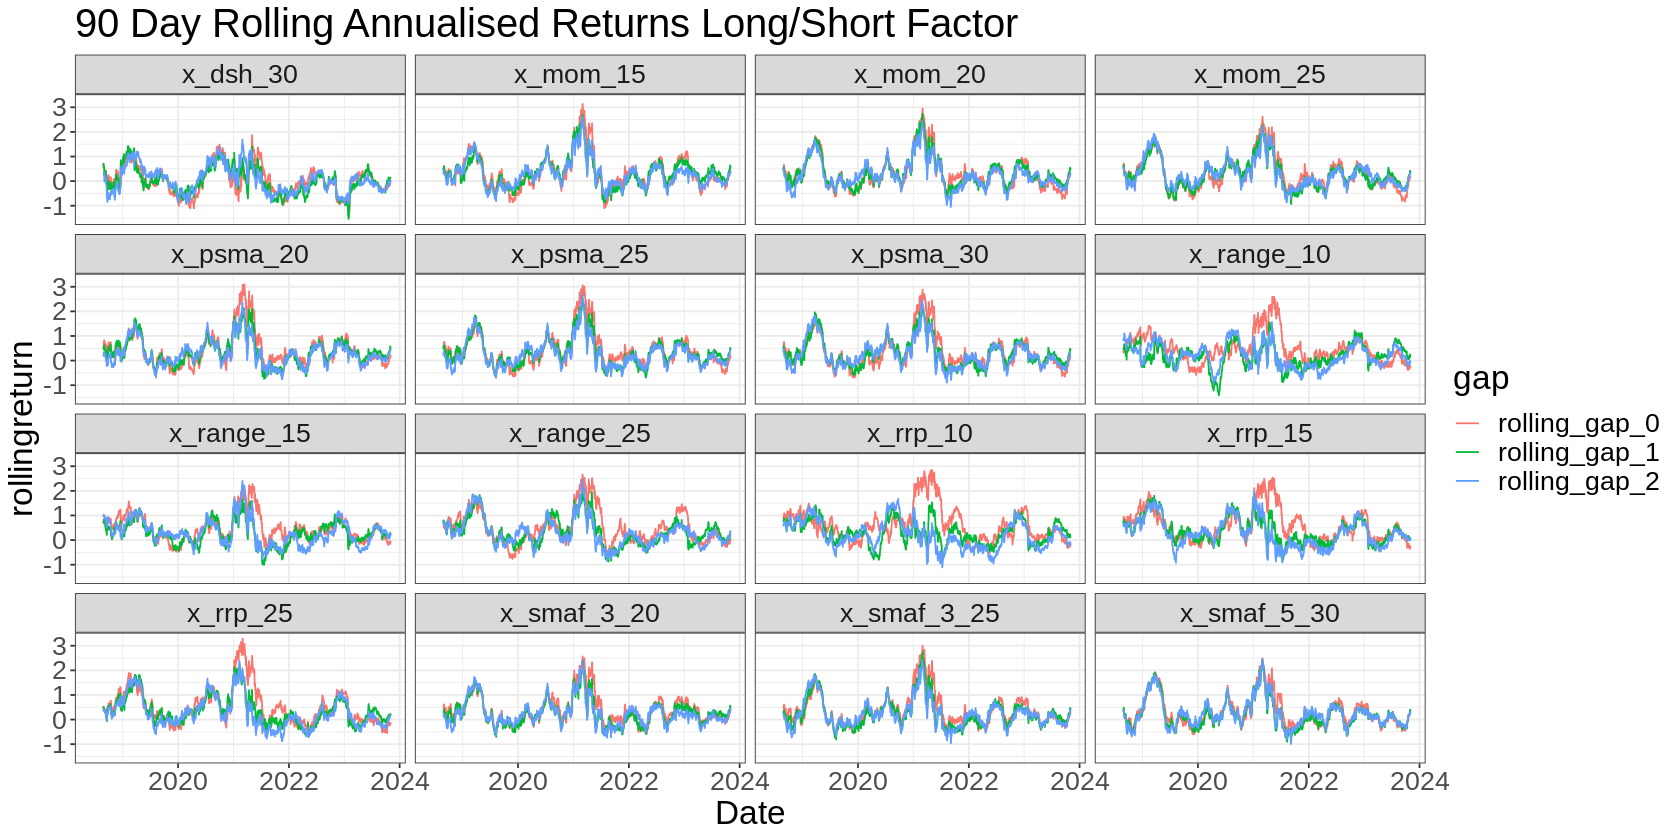

In [133]:
# Rolling Returns Plot
mom_factor %>%
  pivot_longer(starts_with('rolling_gap_'), names_to = 'gap', values_to = 'rollingreturn') %>%
  ggplot(aes(x=Date, y=rollingreturn, color = gap)) +
  geom_line() +
  facet_wrap(~feature) +
  ggtitle('90 Day Rolling Annualised Returns Long/Short Factor')

## Correlations between factor returns

In [136]:
install.packages("Hmisc")
library(Hmisc)

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

also installing the dependencies ‘checkmate’, ‘htmlwidgets’, ‘gridExtra’, ‘htmlTable’, ‘viridis’, ‘Formula’



Attaching package: ‘Hmisc’


The following objects are masked from ‘package:dplyr’:

    src, summarize


The following objects are masked from ‘package:base’:

    format.pval, units




In [137]:
# Cross feature
mom_factor %>%
  select(Date, feature, log_factor_return_1) %>%
  pivot_wider(names_from = feature, values_from = log_factor_return_1) %>%
  select(-Date) %>%
  as.matrix() %>%
  Hmisc::rcorr(type='pearson')

            x_dsh_30 x_mom_15 x_mom_20 x_mom_25 x_psma_20 x_psma_25 x_psma_30
x_dsh_30        1.00     0.47     0.48     0.52      0.46      0.48      0.51
x_mom_15        0.47     1.00     0.86     0.79      0.92      0.92      0.91
x_mom_20        0.48     0.86     1.00     0.90      0.84      0.92      0.93
x_mom_25        0.52     0.79     0.90     1.00      0.75      0.84      0.90
x_psma_20       0.46     0.92     0.84     0.75      1.00      0.96      0.92
x_psma_25       0.48     0.92     0.92     0.84      0.96      1.00      0.97
x_psma_30       0.51     0.91     0.93     0.90      0.92      0.97      1.00
x_range_10      0.34     0.52     0.45     0.40      0.64      0.60      0.56
x_range_15      0.40     0.64     0.54     0.48      0.73      0.68      0.64
x_range_25      0.52     0.70     0.69     0.65      0.75      0.77      0.75
x_rrp_10        0.33     0.54     0.45     0.40      0.67      0.62      0.57
x_rrp_15        0.41     0.64     0.54     0.49      0.76      0

# Mega Factor

`summarise()` has grouped output by 'Date'. You can override using the
`.groups` argument.


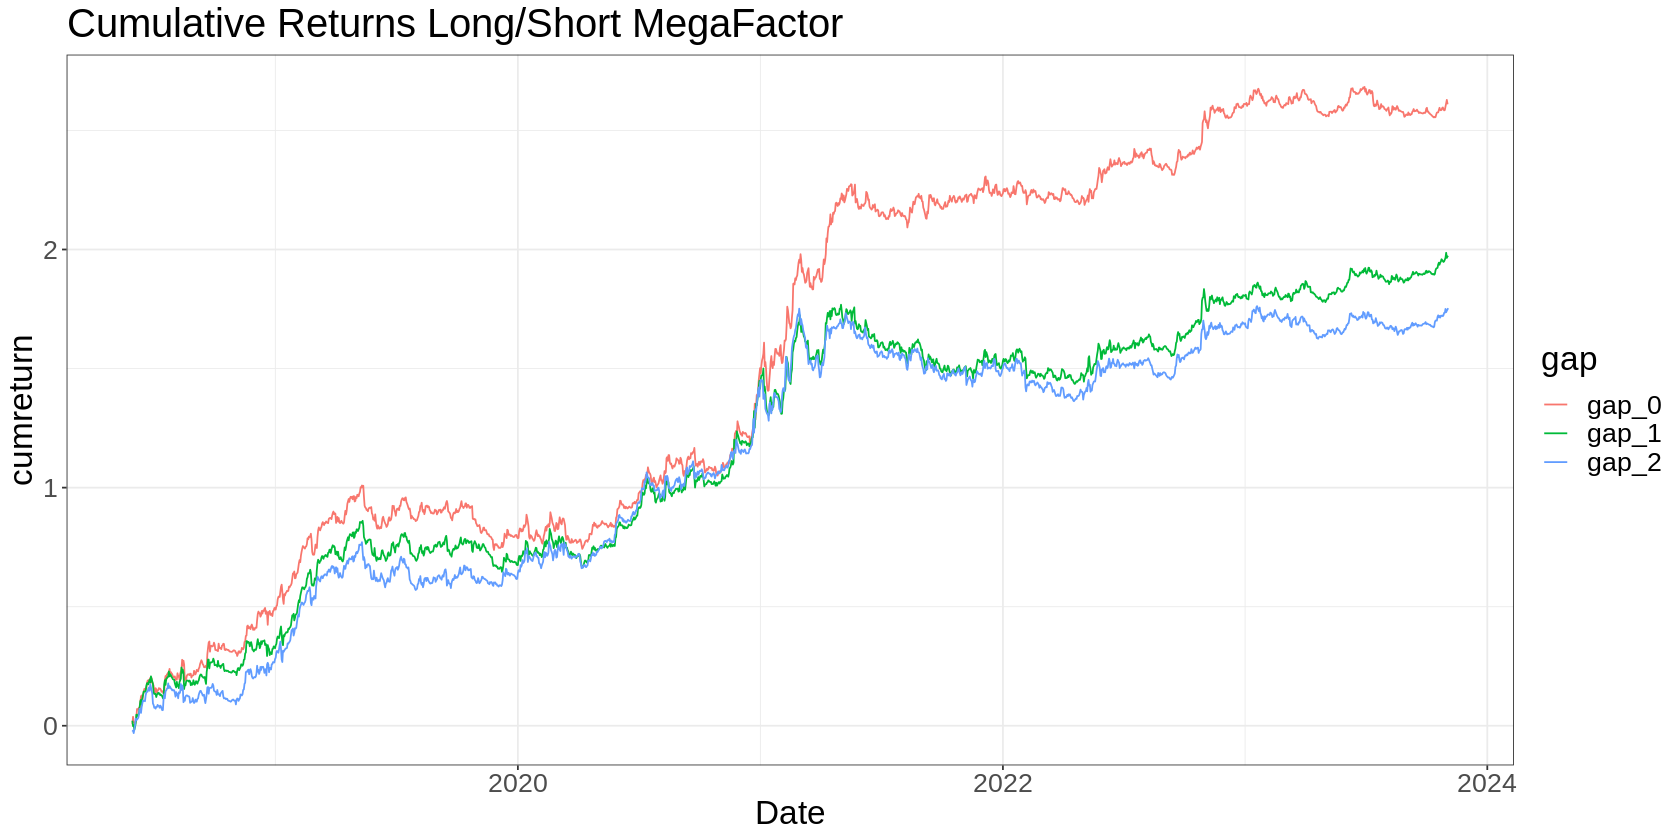

In [138]:
megafactor <- mom_ranks %>%
  group_by(Date, Ticker) %>%
  summarise(megafactor = mean(rank))

megafactor_cumreturns <- megafactor %>%
  inner_join(mom_factor_wide,  by = c('Ticker','Date')) %>%
  mutate(
    weight = megafactor - mean(megafactor),
    scaled_weight = weight/sum(abs(weight)),
    weighted_fwd_return_1 = fwd_return_1 * scaled_weight,
    weighted_fwd_return_2 = fwd_return_2 * scaled_weight,
    weighted_fwd_return_3 = fwd_return_3 * scaled_weight
  ) %>%
  group_by(Date) %>%
  summarise(
    log_factor_return_1 = log(sum(weighted_fwd_return_1) + 1),
    log_factor_return_2 = log(sum(weighted_fwd_return_2) + 1),
    log_factor_return_3 = log(sum(weighted_fwd_return_3) + 1)
  ) %>%
  arrange(Date) %>%
  # Cumulative Returns
  mutate(
    gap_0 = cumsum(log_factor_return_1),
    gap_1 = cumsum(log_factor_return_2),
    gap_2 = cumsum(log_factor_return_3)
  ) %>%
  # Rolling returns
  mutate(
    rolling_gap_0 = roll_meanr(log_factor_return_1, 90) * 365,
    rolling_gap_1 = roll_meanr(log_factor_return_2, 90) * 365,
    rolling_gap_2 = roll_meanr(log_factor_return_3, 90) * 365
  )

megafactor_cumreturns %>%
  pivot_longer(starts_with('gap_'), names_to = 'gap', values_to = 'cumreturn') %>%
  ggplot(aes(x=Date, y=cumreturn, color = gap)) +
    geom_line() +
    ggtitle('Cumulative Returns Long/Short MegaFactor')

`summarise()` has grouped output by 'Date'. You can override using the
`.groups` argument.


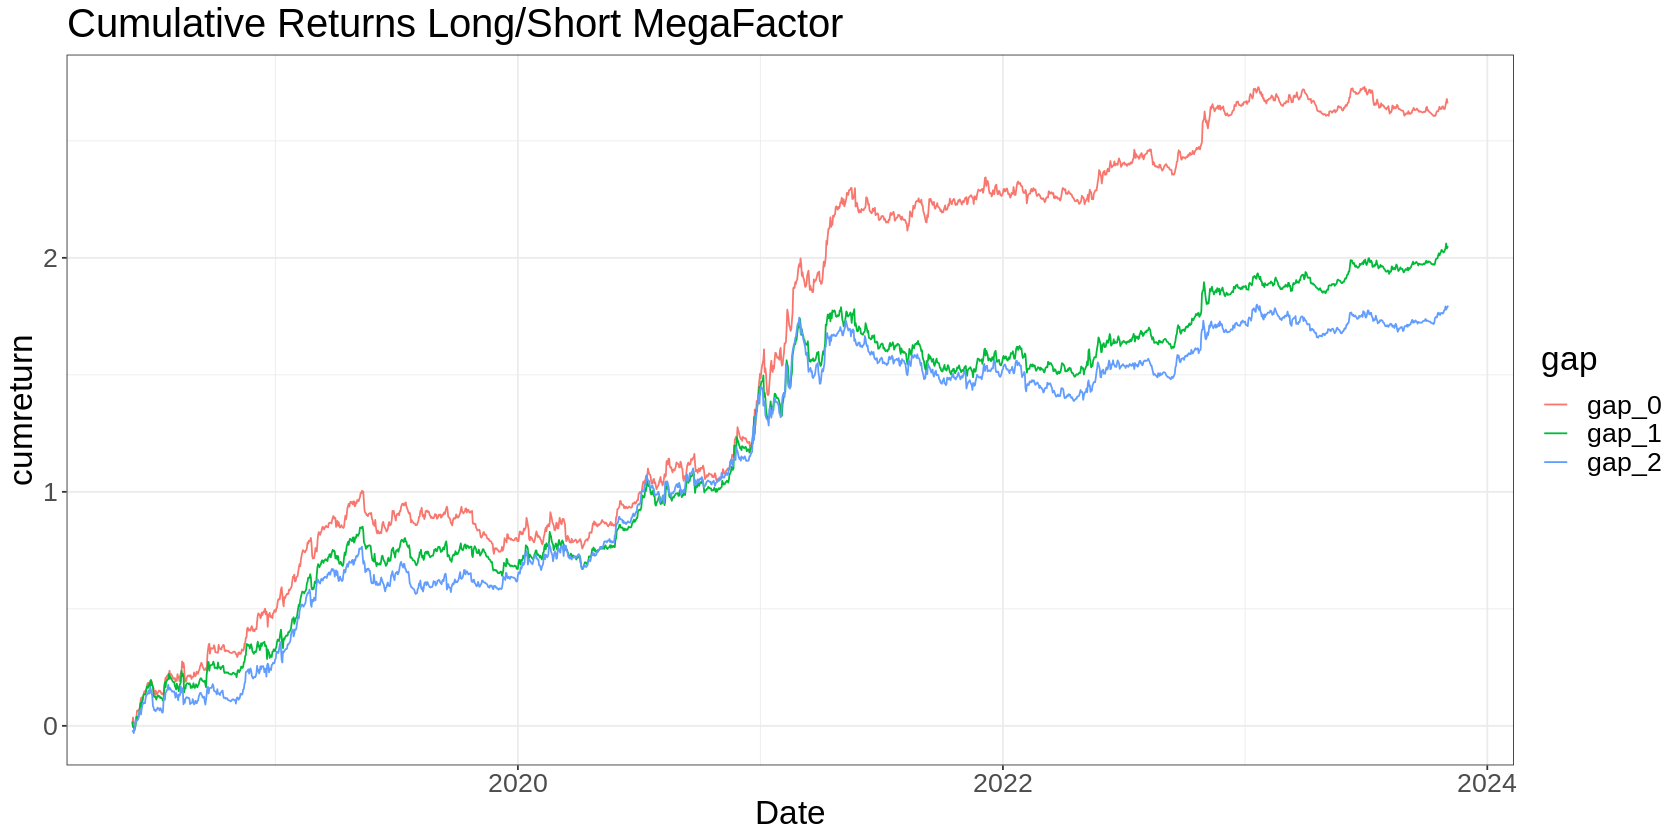

In [139]:
# leave out cross sectional days since high feature
megafactor <- mom_ranks %>%
  filter(feature != "x_dsh_30") %>%
  group_by(Date, Ticker) %>%
  summarise(megafactor = mean(rank))

megafactor_cumreturns <- megafactor %>%
  inner_join(mom_factor_wide,  by = c('Ticker','Date')) %>%
  mutate(
    weight = megafactor - mean(megafactor),
    scaled_weight = weight/sum(abs(weight)),
    weighted_fwd_return_1 = fwd_return_1 * scaled_weight,
    weighted_fwd_return_2 = fwd_return_2 * scaled_weight,
    weighted_fwd_return_3 = fwd_return_3 * scaled_weight
  ) %>%
  group_by(Date) %>%
  summarise(
    log_factor_return_1 = log(sum(weighted_fwd_return_1) + 1),
    log_factor_return_2 = log(sum(weighted_fwd_return_2) + 1),
    log_factor_return_3 = log(sum(weighted_fwd_return_3) + 1)
  ) %>%
  arrange(Date) %>%
  # Cumulative Returns
  mutate(
    gap_0 = cumsum(log_factor_return_1),
    gap_1 = cumsum(log_factor_return_2),
    gap_2 = cumsum(log_factor_return_3)
  ) %>%
  # Rolling returns
  mutate(
    rolling_gap_0 = roll_meanr(log_factor_return_1, 90) * 365,
    rolling_gap_1 = roll_meanr(log_factor_return_2, 90) * 365,
    rolling_gap_2 = roll_meanr(log_factor_return_3, 90) * 365
  )

megafactor_cumreturns %>%
  pivot_longer(starts_with('gap_'), names_to = 'gap', values_to = 'cumreturn') %>%
  ggplot(aes(x=Date, y=cumreturn, color = gap)) +
    geom_line() +
    ggtitle('Cumulative Returns Long/Short MegaFactor')